### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage 
import tqdm
import tensorflow 

from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization,Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

%matplotlib inline

### IMPORTING / VIEWING DATASET 

In [2]:
data = pd.read_csv('../input/facial-key/facial_keypoint_identification/facial_keypoint_identification.csv')

print("Data Imported Successfully")

Data Imported Successfully


In [3]:
# Top Rows

data.head(3)

,image_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.jpg,66,39,30,36
1,1.jpg,64,34,29,33
2,2.jpg,65,34,30,34


In [4]:
# Storing images in numpy array 

X = []

for image in data.image_name:
    img = imread('../input/facial-key/facial_keypoint_identification/images/' + image)
    X.append(img)
    
X = np.array(X)

100%|██████████| 5/5 [00:00<00:00, 143.42it/s]


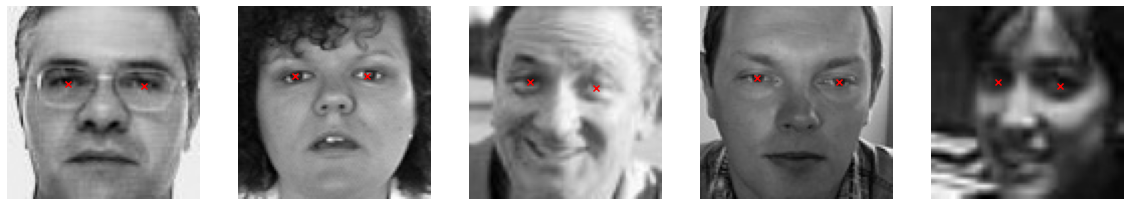

In [5]:
# Viewing Images 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand = np.random.randint(len(data.image_name))
    ax[i].imshow(X[rand])
    ax[i].axis('off')
    ax[i].scatter(data.left_eye_center_x.iloc[rand], data.left_eye_center_y.iloc[rand], marker='x', c='r')
    ax[i].scatter(data.right_eye_center_x.iloc[rand], data.right_eye_center_y.iloc[rand], marker='x', c='r')

After plotting the values we can see that the location of eye is approximatly at the same location. 
Using this we will create simple prediction model that the position of eyes is the mean of all position of the eye. 
This is not the ideal solution and cannot be used in real life but the purpose here is to create benchmark model. 
For doing this we calculate mean square error between our original targets and predictions which is the mean of the column.

In [6]:
# Checking Size 

X.shape

(7033, 96, 96, 3)

### STEP 3: BUILDING MODEL

In [7]:
# Left Eye Centre X

error_left_eye_x = []
mean = data.left_eye_center_x.mean()
nos_of_values = len(data.left_eye_center_x)

for value in data.left_eye_center_x:
    ans = (value - mean) * (value - mean)
    error_left_eye_x.append(ans)
    
error_left_eye_x = np.array(error_left_eye_x)

error_left_eye_x = error_left_eye_x.sum() / nos_of_values
print("MSE: ", error_left_eye_x)

MSE:  11.903676416165595


In [8]:
# Left Eye Centre Y

error_left_eye_y = []
mean = data.left_eye_center_y.mean()
nos_of_values = len(data.left_eye_center_y)

for value in data.left_eye_center_y:
    ans = (value - mean) * (value - mean)
    error_left_eye_y.append(ans)
    
error_left_eye_y = np.array(error_left_eye_y)

error_left_eye_y = error_left_eye_y.sum() / nos_of_values
print("MSE: ", error_left_eye_y)

MSE:  10.027575754518686


In [9]:
# Right Eye Centre X

error_right_eye_x = []
mean = data.right_eye_center_x.mean()
nos_of_values = len(data.right_eye_center_x)

for value in data.right_eye_center_x:
    ans = (value - mean) * (value - mean)
    error_right_eye_x.append(ans)
    
error_right_eye_x = np.array(error_right_eye_x)

error_right_eye_x = error_right_eye_x.sum() / nos_of_values
print("MSE: ", error_right_eye_x)

MSE:  9.453030197932037


In [10]:
# Right Eye Centre Y

error_right_eye_y = []
mean = data.right_eye_center_y.mean()
nos_of_values = len(data.right_eye_center_y)

for value in data.right_eye_center_y:
    ans = (value - mean) * (value - mean)
    error_right_eye_y.append(ans)
    
error_right_eye_y = np.array(error_right_eye_y)

error_right_eye_y = error_right_eye_y.sum() / nos_of_values
print("MSE: ", error_right_eye_y)

MSE:  9.311627747308707


In [11]:
# Final Error

error = ((error_left_eye_x * error_left_eye_x) + (error_left_eye_y * error_left_eye_y) + (error_right_eye_x * error_right_eye_x) + (error_right_eye_y * error_right_eye_y)) / 4
error

104.5789947402131

In [12]:
# Resizing Images 

Images = []

for image in data.image_name:
    img = imread('../input/facial-key/facial_keypoint_identification/images/' + image)
    img = resize(img, (96,96,3))
    Images.append(img)
    
Images = np.array(Images)

In [13]:
# Checking Shape 

Images.shape

(7033, 96, 96, 3)

In [14]:
# Setting Independent and Dependent Variable 

X = Images 
y = data.iloc[:, 1:].values

In [15]:
# Checking min and max values 

X.min(), X.max()

(0.0, 1.0)

In [16]:
# Setting Train & Test Data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape

((5626, 96, 96, 3), (1407, 96, 96, 3))

In [17]:
# Base Model

base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (96,96,3))

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
# Freezing Layers 

for layers in base_model.layers:
    layers.trainable = False

In [19]:
# Building Layers 

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='linear'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4608)              18432     
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [20]:
# Compiling Model

model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr = 0.001), 
              loss='mean_squared_error')

In [21]:
# Defining Callbacks 

earlystopping  = EarlyStopping(monitor = 'val_loss',
                               mode = 'min',
                               patience = 15,
                               min_delta = 0.001)

callback_list = [earlystopping]

In [22]:
# Fitting Model

model_history = model.fit(x = X_train, 
                          y = y_train, 
                          validation_data = (X_test, y_test),
                          batch_size = len(X_train) // 256,
                          epochs = 200,
                          callbacks = callback_list)

Epoch 1/200
268/268 [==============================] - 6s 21ms/step - loss: 330.5185 - val_loss: 29.4793
Epoch 2/200
268/268 [==============================] - 5s 19ms/step - loss: 16.3820 - val_loss: 18.0844
Epoch 3/200
268/268 [==============================] - 5s 19ms/step - loss: 14.2773 - val_loss: 17.5565
Epoch 4/200
268/268 [==============================] - 5s 19ms/step - loss: 13.0381 - val_loss: 14.8628
Epoch 5/200
268/268 [==============================] - 5s 19ms/step - loss: 11.9026 - val_loss: 12.0976
Epoch 6/200
268/268 [==============================] - 5s 20ms/step - loss: 10.8755 - val_loss: 10.1095
Epoch 7/200
268/268 [==============================] - 5s 19ms/step - loss: 10.3273 - val_loss: 11.6176
Epoch 8/200
268/268 [==============================] - 5s 19ms/step - loss: 9.9829 - val_loss: 10.9490
Epoch 9/200
268/268 [==============================] - 5s 19ms/step - loss: 9.6176 - val_loss: 10.7237
Epoch 10/200
268/268 [==============================] - 5s 19ms/s

In [23]:
predictions = model.predict(X_test)
predictions[0:5]

array([[65.562904, 39.30094 , 28.256643, 35.91193 ],
       [67.96889 , 39.356617, 30.942461, 36.1437  ],
       [60.35021 , 43.22847 , 32.89026 , 46.069603],
       [65.16043 , 38.98413 , 31.470022, 36.770935],
       [66.83944 , 37.533062, 29.303589, 34.89383 ]], dtype=float32)

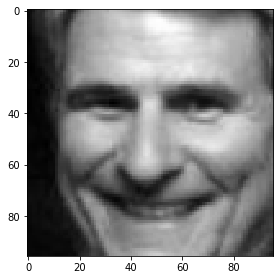

In [24]:
rand = np.random.randint(len(X_test))
imshow(X_test[rand])

100%|██████████| 5/5 [00:00<00:00, 97.34it/s]


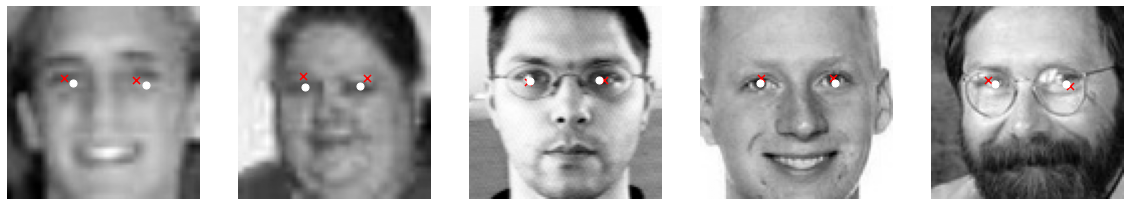

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
predictions = model.predict(X_test)

for i in tqdm(range(5)):
    rand = np.random.randint(len(X_test))
    ax[i].imshow(X_test[rand])
    ax[i].axis('off')
    ax[i].scatter(data.left_eye_center_x.iloc[rand], data.left_eye_center_y.iloc[rand], marker='x', s=50, c='r')
    ax[i].scatter(data.right_eye_center_x.iloc[rand], data.right_eye_center_y.iloc[rand], marker='x', s=50, c='r')
    
    predicted_left_eye_center_x, predicted_left_eye_center_y, predicted_right_eye_center_x, predicted_right_eye_center_y = predictions[rand]
    
    ax[i].scatter(predicted_left_eye_center_x, predicted_left_eye_center_y, marker='o', s=50, c='w')
    ax[i].scatter(predicted_right_eye_center_x, predicted_right_eye_center_y, marker='o', s=50, c='w')